In [8]:
import astropy.units as u
import astropy.constants as const
from astroduet.duet_telescope import load_telescope_parameters
from astroduet.duet_sensitivity import src_rate, bgd_sky_qe_rate, bgd_electronics, calc_exposure, calc_snr
from astroduet.duet_neff import get_neff
from astroduet.bbmag import bb_abmag_fluence, bb_abmag
import numpy as np
from matplotlib import pyplot as plt
from astropy.table import Table

from astropy.visualization import quantity_support
import matplotlib
font = {'family' : 'sans',
        'weight' : 'bold',
        'size'   : 18}

matplotlib.rc('font', **font)

In [2]:
plt.rcParams['figure.figsize'] = [12,8]

In [3]:
# Telescope setup
read_noise = 3.*(2**0.5) # Read noise for two frames

point_drift = 1*u.arcsec # To be added to the PSF in quadrature
point_jitter = 5*u.arcsec
# Define bands
td1_band = [193, 233]*u.nm


# Transmission efficiency
trans_eff = (0.975)**8 # from Jim. 

print('Transmission efficiency: {}'.format(trans_eff))

# Load telescope info
config=11
diameter, qe, psf_size, pixel_size, efficiency = load_telescope_parameters(config)

area = np.pi * (diameter*0.5)**2
area_onaxis = np.pi * (0.5*24.2*u.cm)**2
efficiency = area_onaxis / area

print('Effective area (used) {}'.format(area*efficiency))



# Add in fuzz...
psf_size = (psf_size**2 + point_drift**2 + point_jitter**2)**0.5


print('Effective PSF size {}'.format(psf_size))
# Get the number of effective background pixels
neff = get_neff(psf_size, pixel_size)
print('Number of effective bgd pixels: {}'.format(neff))
print()

Transmission efficiency: 0.8166518036622619
Telescope Configuration 11
Name: Small Focal Plane CMOS
Entrance Pupil diameter 26.0 cm
Optical Efficiency 0.7893639053254439
PSF FWHM 4.288 arcsec
Pixel size 6.4 arcsec
Effective Aperture 23.1 cm
Effective Area 419.09631397051237 cm2
Effective area (used) 459.9605804120816 cm2
Effective PSF size 6.6623527375845235 arcsec
Number of effective bgd pixels: 2.990374488245114



In [11]:
# Other settings and background computation
light=True
texp = 300*u.s

dist0 = 10*u.pc
dist = [50,100,200]*u.Mpc

colerr = 0.1 # Error on color in magnitudes

ab_vega = 1.73 # AB-Vega offset for Swift magnitudes

# Compute sky background
bgd_ph_rate = bgd_sky_qe_rate(low_zodi=True,
                              diameter=diameter,
                              pixel_size=pixel_size, real_red=True, light=light)
bgd_band1 = trans_eff * efficiency * bgd_ph_rate
print('Sky background rate per pixel band1: {}'.format(bgd_band1))

bgd_ph_rate = bgd_sky_qe_rate(low_zodi=True,
                              diameter=diameter,
                              qe_band=2,
                              pixel_size=pixel_size, real_red=True, light=light)
bgd_band2 = trans_eff  * efficiency * bgd_ph_rate
print('Sky background rate per pixel band2: {}'.format(bgd_band2))


center = 208
width = 53
bandone=[center - 0.5*width, center+0.5*width]*u.nm

center = 284
width = 68
bandtwo=[center - 0.5*width, center+0.5*width]*u.nm

Sky background rate per pixel band1: 0.030369732491096913 1 / s
Sky background rate per pixel band2: 0.2478588509265617 1 / s


/Users/mheida/software/miniconda2/envs/duet/lib/python3.6/site-packages/scipy/stats/_binned_statistic.py:607: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  result = result[core]


In [5]:
# Load Tony's lightcurves
shock_2e10 = np.loadtxt('../astroduet/data/shock_2.5e10.dat')
shock_5e10 = np.loadtxt('../astroduet/data/shock_5e10.dat')
shock_1e11 = np.loadtxt('../astroduet/data/shock_1e11.dat')
blukn_01 = np.loadtxt('../astroduet/data/kilonova_0.01.dat')
blukn_02 = np.loadtxt('../astroduet/data/kilonova_0.02.dat')
blukn_04 = np.loadtxt('../astroduet/data/kilonova_0.04.dat')

In [6]:
# Calculate absolute ABmags and photon rates in DUET bands for both models:

shock_2e10_lc = Table([shock_2e10[:,0]*u.s,np.zeros(len(shock_2e10))*u.ABmag,np.zeros(len(shock_2e10))*u.ABmag,np.zeros(len(shock_2e10))*1/(u.s*u.cm**2),np.zeros(len(shock_2e10))*1/(u.s*u.cm**2)],
               names=('time', 'mag_D1', 'mag_D2', 'photflux_D1', 'photflux_D2'), meta={'name': 'Shock model - radius 2.5e10 cm - mags and photon flux at 10pc'})

for k in range(len(shock_2e10[:,0])): 
    bolflux = 10**shock_2e10[k,1] * (u.erg/u.s) /(4 * np.pi * dist0**2)
    band1_mag, band2_mag = bb_abmag(bbtemp=shock_2e10[k,2]*u.K, bandone=bandone, 
                            bandtwo=bandtwo, bolflux=bolflux, val=True)
    band1_fluence, band2_fluence = bb_abmag_fluence(bbtemp=shock_2e10[k,2]*u.K,
                            bolflux=bolflux, light=light)
    shock_2e10_lc[k]['mag_D1'],shock_2e10_lc[k]['mag_D2'] = band1_mag,band2_mag
    shock_2e10_lc[k]['photflux_D1'],shock_2e10_lc[k]['photflux_D2'] = band1_fluence.value,band2_fluence.value

shock_5e10_lc = Table([shock_5e10[:,0]*u.s,np.zeros(len(shock_5e10))*u.ABmag,np.zeros(len(shock_5e10))*u.ABmag,np.zeros(len(shock_5e10))*1/(u.s*u.cm**2),np.zeros(len(shock_5e10))*1/(u.s*u.cm**2)],
               names=('time', 'mag_D1', 'mag_D2', 'photflux_D1', 'photflux_D2'), meta={'name': 'Shock model - radius 5e10 cm - mags and photon flux at 10pc'})

for k in range(len(shock_5e10[:,0])): 
    bolflux = 10**shock_5e10[k,1] * (u.erg/u.s) /(4 * np.pi * dist0**2)
    band1_mag, band2_mag = bb_abmag(bbtemp=shock_5e10[k,2]*u.K, bandone=bandone, 
                            bandtwo=bandtwo, bolflux=bolflux, val=True)
    band1_fluence, band2_fluence = bb_abmag_fluence(bbtemp=shock_5e10[k,2]*u.K,
                            bolflux=bolflux, light=light)
    shock_5e10_lc[k]['mag_D1'],shock_5e10_lc[k]['mag_D2'] = band1_mag,band2_mag
    shock_5e10_lc[k]['photflux_D1'],shock_5e10_lc[k]['photflux_D2'] = band1_fluence.value,band2_fluence.value

shock_1e11_lc = Table([shock_1e11[:,0]*u.s,np.zeros(len(shock_1e11))*u.ABmag,np.zeros(len(shock_1e11))*u.ABmag,np.zeros(len(shock_1e11))*1/(u.s*u.cm**2),np.zeros(len(shock_1e11))*1/(u.s*u.cm**2)],
               names=('time', 'mag_D1', 'mag_D2', 'photflux_D1', 'photflux_D2'), meta={'name': 'Shock model - radius 1e11 cm - mags and photon flux at 10pc'})

for k in range(len(shock_1e11[:,0])): 
    bolflux = 10**shock_1e11[k,1] * (u.erg/u.s) /(4 * np.pi * dist0**2)
    band1_mag, band2_mag = bb_abmag(bbtemp=shock_1e11[k,2]*u.K, bandone=bandone, 
                            bandtwo=bandtwo, bolflux=bolflux,val=True)
    band1_fluence, band2_fluence = bb_abmag_fluence(bbtemp=shock_1e11[k,2]*u.K,
                            bolflux=bolflux, light=light)
    shock_1e11_lc[k]['mag_D1'],shock_1e11_lc[k]['mag_D2'] = band1_mag,band2_mag
    shock_1e11_lc[k]['photflux_D1'],shock_1e11_lc[k]['photflux_D2'] = band1_fluence.value,band2_fluence.value

        
blukn_01_lc = Table([blukn_01[:,0]*u.s,np.zeros(len(blukn_01))*u.ABmag,np.zeros(len(blukn_01))*u.ABmag,np.zeros(len(blukn_01))*1/(u.s*u.cm**2),np.zeros(len(blukn_01))*1/(u.s*u.cm**2)],
               names=('time', 'mag_D1', 'mag_D2', 'photflux_D1', 'photflux_D2'), meta={'name': 'Blue kilonova model - mass 0.01 Msun - mags and photon flux at 10pc'})

for k in range(len(blukn_01[:,0])): 
    bolflux = 10**blukn_01[k,1] * (u.erg/u.s) /(4 * np.pi * dist0**2)
    band1_mag, band2_mag = bb_abmag(bbtemp=blukn_01[k,2]*u.K, bandone=bandone, 
                              bandtwo=bandtwo, bolflux=bolflux, val=True)
    band1_fluence, band2_fluence = bb_abmag_fluence(bbtemp=blukn_01[k,2]*u.K,
                            bolflux=bolflux, light=light)
    blukn_01_lc[k]['mag_D1'],blukn_01_lc[k]['mag_D2'] = band1_mag,band2_mag
    blukn_01_lc[k]['photflux_D1'],blukn_01_lc[k]['photflux_D2'] = band1_fluence.value,band2_fluence.value

blukn_02_lc = Table([blukn_02[:,0]*u.s,np.zeros(len(blukn_02))*u.ABmag,np.zeros(len(blukn_02))*u.ABmag,np.zeros(len(blukn_02))*1/(u.s*u.cm**2),np.zeros(len(blukn_02))*1/(u.s*u.cm**2)],
               names=('time', 'mag_D1', 'mag_D2', 'photflux_D1', 'photflux_D2'), meta={'name': 'Blue kilonova model - mass 0.02 Msun - mags and photon flux at 10pc'})

for k in range(len(blukn_02[:,0])): 
    bolflux = 10**blukn_02[k,1] * (u.erg/u.s) /(4 * np.pi * dist0**2)
    band1_mag, band2_mag = bb_abmag(bbtemp=blukn_02[k,2]*u.K, bandone=bandone, 
                              bandtwo=bandtwo, bolflux=bolflux, val=True)
    band1_fluence, band2_fluence = bb_abmag_fluence(bbtemp=blukn_02[k,2]*u.K,
                            bolflux=bolflux, light=light)
    blukn_02_lc[k]['mag_D1'],blukn_02_lc[k]['mag_D2'] = band1_mag,band2_mag
    blukn_02_lc[k]['photflux_D1'],blukn_02_lc[k]['photflux_D2'] = band1_fluence.value,band2_fluence.value

blukn_04_lc = Table([blukn_04[:,0]*u.s,np.zeros(len(blukn_04))*u.ABmag,np.zeros(len(blukn_04))*u.ABmag,np.zeros(len(blukn_04))*1/(u.s*u.cm**2),np.zeros(len(blukn_04))*1/(u.s*u.cm**2)],
               names=('time', 'mag_D1', 'mag_D2', 'photflux_D1', 'photflux_D2'), meta={'name': 'Blue kilonova model - mass 0.04 Msun - mags and photon flux at 10pc'})

for k in range(len(blukn_04[:,0])): 
    bolflux = 10**blukn_04[k,1] * (u.erg/u.s) /(4 * np.pi * dist0**2)
    band1_mag, band2_mag = bb_abmag(bbtemp=blukn_04[k,2]*u.K, bandone=bandone, 
                              bandtwo=bandtwo, bolflux=bolflux, val=True)
    band1_fluence, band2_fluence = bb_abmag_fluence(bbtemp=blukn_04[k,2]*u.K,
                            bolflux=bolflux, light=light)
    blukn_04_lc[k]['mag_D1'],blukn_04_lc[k]['mag_D2'] = band1_mag,band2_mag
    blukn_04_lc[k]['photflux_D1'],blukn_04_lc[k]['photflux_D2'] = band1_fluence.value,band2_fluence.value



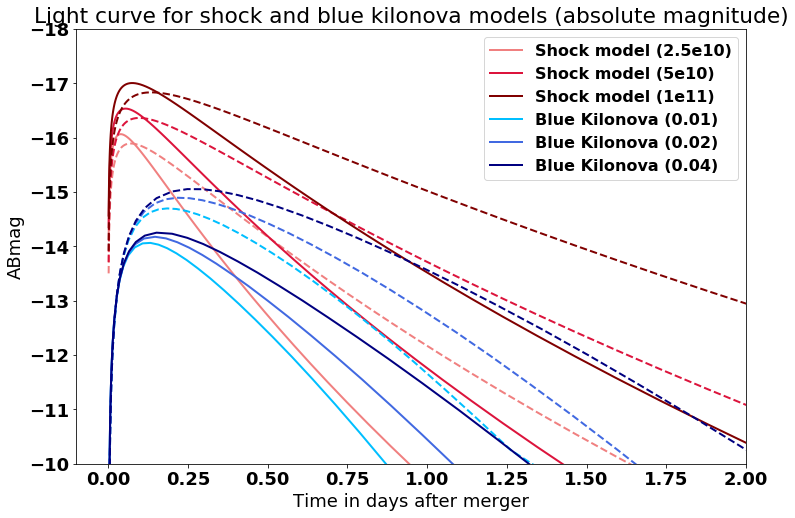

In [9]:
plt.plot(shock_2e10_lc['time'],shock_2e10_lc['mag_D1'], color='lightcoral', linestyle='-', linewidth=2, label='Shock model (2.5e10)')
plt.plot(shock_2e10_lc['time'],shock_2e10_lc['mag_D2'], color='lightcoral', linestyle='--', linewidth=2, label='_Shock model (2.5e10)')
plt.plot(shock_5e10_lc['time'],shock_5e10_lc['mag_D1'], color='crimson', linestyle='-', linewidth=2, label='Shock model (5e10)')
plt.plot(shock_5e10_lc['time'],shock_5e10_lc['mag_D2'], color='crimson', linestyle='--', linewidth=2, label='_Shock model (5e10)')
plt.plot(shock_1e11_lc['time'],shock_1e11_lc['mag_D1'], color='maroon', linestyle='-', linewidth=2, label='Shock model (1e11)')
plt.plot(shock_1e11_lc['time'],shock_1e11_lc['mag_D2'], color='maroon', linestyle='--', linewidth=2, label='_Shock model (1e11)')

plt.plot(blukn_01_lc['time'],blukn_01_lc['mag_D1'], color='deepskyblue', linestyle='-', linewidth=2, label='Blue Kilonova (0.01)')
plt.plot(blukn_01_lc['time'],blukn_01_lc['mag_D2'], color='deepskyblue', linestyle='--', linewidth=2, label='_Blue Kilonova (0.01)')
plt.plot(blukn_02_lc['time'],blukn_02_lc['mag_D1'], color='royalblue', linestyle='-', linewidth=2, label='Blue Kilonova (0.02)')
plt.plot(blukn_02_lc['time'],blukn_02_lc['mag_D2'], color='royalblue', linestyle='--', linewidth=2, label='_Blue Kilonova (0.02)')
plt.plot(blukn_04_lc['time'],blukn_04_lc['mag_D1'], color='navy', linestyle='-', linewidth=2, label='Blue Kilonova (0.04)')
plt.plot(blukn_04_lc['time'],blukn_04_lc['mag_D2'], color='navy', linestyle='--', linewidth=2, label='_Blue Kilonova (0.04)')

plt.axhline(y=22,xmin=0,xmax=1,color='black',linestyle=':')
plt.ylim(-10,-18)
plt.xlim(-0.1,2)
plt.legend(fontsize=16)
plt.xlabel('Time in days after merger')
plt.ylabel(r'ABmag')
plt.title('Light curve for shock and blue kilonova models (absolute magnitude)')
plt.show()

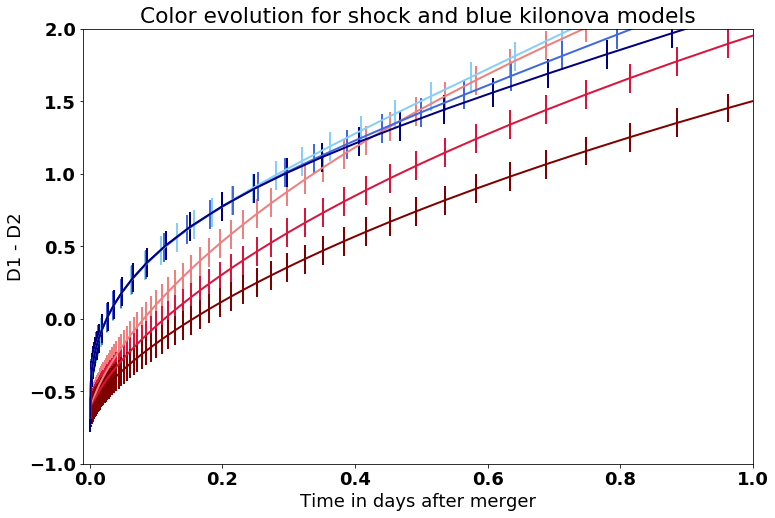

In [14]:
plt.errorbar(shock_2e10_lc['time'],shock_2e10_lc['mag_D1']-shock_2e10_lc['mag_D2'],yerr=colerr, linewidth=2, color='lightcoral', label='Shock model')
plt.errorbar(shock_5e10_lc['time'],shock_5e10_lc['mag_D1']-shock_5e10_lc['mag_D2'],yerr=colerr, linewidth=2, color='crimson', label='Shock model')
plt.errorbar(shock_1e11_lc['time'],shock_1e11_lc['mag_D1']-shock_1e11_lc['mag_D2'],yerr=colerr, linewidth=2, color='maroon', label='Shock model')
plt.errorbar(blukn_01_lc['time'],blukn_01_lc['mag_D1']-blukn_01_lc['mag_D2'],yerr=colerr ,linewidth=2, color='lightskyblue', label='Blue kilonova')
plt.errorbar(blukn_02_lc['time'],blukn_02_lc['mag_D1']-blukn_02_lc['mag_D2'],yerr=colerr ,linewidth=2, color='royalblue', label='Blue kilonova')
plt.errorbar(blukn_04_lc['time'],blukn_04_lc['mag_D1']-blukn_04_lc['mag_D2'],yerr=colerr ,linewidth=2, color='navy', label='Blue kilonova')

plt.ylim(-1,2)
plt.xlim(-0.01,1)
#plt.legend()
plt.xlabel('Time in days after merger')
plt.ylabel(r'D1 - D2')
plt.title('Color evolution for shock and blue kilonova models')
plt.show()

In [15]:
# Calculate S/N for both models:

shock_2e10_snr = np.zeros([len(dist),len(shock_2e10[:,0]),3])
shock_2e10_snr[:,:,0] = shock_2e10[:,0]
for j, distval in enumerate(dist):
    band1_fluence = shock_2e10_lc['photflux_D1'].quantity*(dist0.to(u.pc)/distval.to(u.pc))**2
    band2_fluence = shock_2e10_lc['photflux_D2'].quantity*(dist0.to(u.pc)/distval.to(u.pc))**2
    band1_rate = trans_eff * efficiency * area * band1_fluence
    band2_rate = trans_eff * efficiency * area * band2_fluence
    snr1 = calc_snr(texp, band1_rate, bgd_band1, read_noise, neff)
    snr2 = calc_snr(texp, band2_rate, bgd_band2, read_noise, neff)
    shock_2e10_snr[j,:,1] = snr1
    shock_2e10_snr[j,:,2] = snr2

shock_5e10_snr = np.zeros([len(dist),len(shock_5e10[:,0]),3])
shock_5e10_snr[:,:,0] = shock_5e10[:,0]
for j, distval in enumerate(dist):
    band1_fluence = shock_5e10_lc['photflux_D1'].quantity*(dist0.to(u.pc)/distval.to(u.pc))**2
    band2_fluence = shock_5e10_lc['photflux_D2'].quantity*(dist0.to(u.pc)/distval.to(u.pc))**2
    band1_rate = trans_eff * efficiency * area * band1_fluence
    band2_rate = trans_eff * efficiency * area * band2_fluence
    snr1 = calc_snr(texp, band1_rate, bgd_band1, read_noise, neff)
    snr2 = calc_snr(texp, band2_rate, bgd_band2, read_noise, neff)
    shock_5e10_snr[j,:,1] = snr1
    shock_5e10_snr[j,:,2] = snr2

shock_1e11_snr = np.zeros([len(dist),len(shock_1e11[:,0]),3])
shock_1e11_snr[:,:,0] = shock_1e11[:,0]
for j, distval in enumerate(dist):
    band1_fluence = shock_1e11_lc['photflux_D1'].quantity*(dist0.to(u.pc)/distval.to(u.pc))**2
    band2_fluence = shock_1e11_lc['photflux_D2'].quantity*(dist0.to(u.pc)/distval.to(u.pc))**2
    band1_rate = trans_eff * efficiency * area * band1_fluence
    band2_rate = trans_eff * efficiency * area * band2_fluence
    snr1 = calc_snr(texp, band1_rate, bgd_band1, read_noise, neff)
    snr2 = calc_snr(texp, band2_rate, bgd_band2, read_noise, neff)
    shock_1e11_snr[j,:,1] = snr1
    shock_1e11_snr[j,:,2] = snr2

blukn_01_snr = np.zeros([len(dist),len(blukn_01[:,0]),3])
blukn_01_snr[:,:,0] = blukn_01[:,0]
for j, distval in enumerate(dist):
    band1_fluence = blukn_01_lc['photflux_D1'].quantity*(dist0.to(u.pc)/distval.to(u.pc))**2
    band2_fluence = blukn_01_lc['photflux_D2'].quantity*(dist0.to(u.pc)/distval.to(u.pc))**2
    band1_rate = trans_eff * efficiency * area * band1_fluence
    band2_rate = trans_eff * efficiency * area * band2_fluence
    snr1 = calc_snr(texp, band1_rate, bgd_band1, read_noise, neff)
    snr2 = calc_snr(texp, band2_rate, bgd_band2, read_noise, neff)
    blukn_01_snr[j,:,1] = snr1
    blukn_01_snr[j,:,2] = snr2
        
blukn_02_snr = np.zeros([len(dist),len(blukn_02[:,0]),3])
blukn_02_snr[:,:,0] = blukn_02[:,0]
for j, distval in enumerate(dist):
    band1_fluence = blukn_02_lc['photflux_D1'].quantity*(dist0.to(u.pc)/distval.to(u.pc))**2
    band2_fluence = blukn_02_lc['photflux_D2'].quantity*(dist0.to(u.pc)/distval.to(u.pc))**2
    band1_rate = trans_eff * efficiency * area * band1_fluence
    band2_rate = trans_eff * efficiency * area * band2_fluence
    snr1 = calc_snr(texp, band1_rate, bgd_band1, read_noise, neff)
    snr2 = calc_snr(texp, band2_rate, bgd_band2, read_noise, neff)
    blukn_02_snr[j,:,1] = snr1
    blukn_02_snr[j,:,2] = snr2

blukn_04_snr = np.zeros([len(dist),len(blukn_04[:,0]),3])
blukn_04_snr[:,:,0] = blukn_04[:,0]
for j, distval in enumerate(dist):
    band1_fluence = blukn_04_lc['photflux_D1'].quantity*(dist0.to(u.pc)/distval.to(u.pc))**2
    band2_fluence = blukn_04_lc['photflux_D2'].quantity*(dist0.to(u.pc)/distval.to(u.pc))**2
    band1_rate = trans_eff * efficiency * area * band1_fluence
    band2_rate = trans_eff * efficiency * area * band2_fluence
    snr1 = calc_snr(texp, band1_rate, bgd_band1, read_noise, neff)
    snr2 = calc_snr(texp, band2_rate, bgd_band2, read_noise, neff)
    blukn_04_snr[j,:,1] = snr1
    blukn_04_snr[j,:,2] = snr2

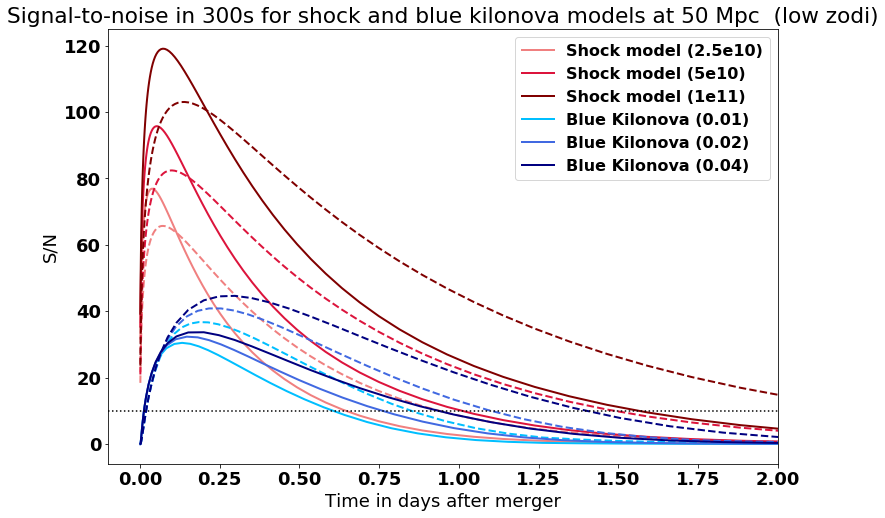

In [16]:
plt.plot(shock_2e10_snr[0,:,0],shock_2e10_snr[0,:,1], color='lightcoral', linestyle='-', linewidth=2, label='Shock model (2.5e10)')
plt.plot(shock_2e10_snr[0,:,0],shock_2e10_snr[0,:,2], color='lightcoral', linestyle='--', linewidth=2, label='_Shock model (2.5e10)')
plt.plot(shock_5e10_snr[0,:,0],shock_5e10_snr[0,:,1], color='crimson', linestyle='-', linewidth=2, label='Shock model (5e10)')
plt.plot(shock_5e10_snr[0,:,0],shock_5e10_snr[0,:,2], color='crimson', linestyle='--', linewidth=2, label='_Shock model (5e10)')
plt.plot(shock_1e11_snr[0,:,0],shock_1e11_snr[0,:,1], color='maroon', linestyle='-', linewidth=2, label='Shock model (1e11)')
plt.plot(shock_1e11_snr[0,:,0],shock_1e11_snr[0,:,2], color='maroon', linestyle='--', linewidth=2, label='_Shock model (1e11)')

plt.plot(blukn_01_snr[0,:,0],blukn_01_snr[0,:,1], color='deepskyblue', linestyle='-', linewidth=2, label='Blue Kilonova (0.01)')
plt.plot(blukn_01_snr[0,:,0],blukn_01_snr[0,:,2], color='deepskyblue', linestyle='--', linewidth=2, label='_Blue Kilonova (0.01)')
plt.plot(blukn_02_snr[0,:,0],blukn_02_snr[0,:,1], color='royalblue', linestyle='-', linewidth=2, label='Blue Kilonova (0.02)')
plt.plot(blukn_02_snr[0,:,0],blukn_02_snr[0,:,2], color='royalblue', linestyle='--', linewidth=2, label='_Blue Kilonova (0.02)')
plt.plot(blukn_04_snr[0,:,0],blukn_04_snr[0,:,1], color='navy', linestyle='-', linewidth=2, label='Blue Kilonova (0.04)')
plt.plot(blukn_04_snr[0,:,0],blukn_04_snr[0,:,2], color='navy', linestyle='--', linewidth=2, label='_Blue Kilonova (0.04)')

plt.axhline(y=10,xmin=0,xmax=1,color='black',linestyle=':')
#plt.ylim(26,18)
plt.xlim(-0.1,2)
plt.legend(fontsize=16)
plt.xlabel('Time in days after merger')
plt.ylabel(r'S/N')
plt.title('Signal-to-noise in 300s for shock and blue kilonova models at 50 Mpc  (low zodi)')
plt.show()

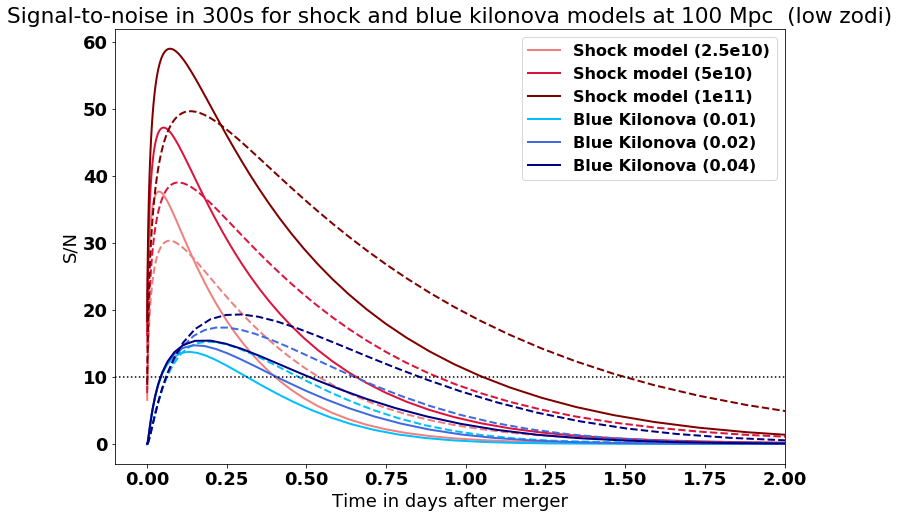

In [17]:
plt.plot(shock_2e10_snr[1,:,0],shock_2e10_snr[1,:,1], color='lightcoral', linestyle='-', linewidth=2, label='Shock model (2.5e10)')
plt.plot(shock_2e10_snr[1,:,0],shock_2e10_snr[1,:,2], color='lightcoral', linestyle='--', linewidth=2, label='_Shock model (2.5e10)')
plt.plot(shock_5e10_snr[1,:,0],shock_5e10_snr[1,:,1], color='crimson', linestyle='-', linewidth=2, label='Shock model (5e10)')
plt.plot(shock_5e10_snr[1,:,0],shock_5e10_snr[1,:,2], color='crimson', linestyle='--', linewidth=2, label='_Shock model (5e10)')
plt.plot(shock_1e11_snr[1,:,0],shock_1e11_snr[1,:,1], color='maroon', linestyle='-', linewidth=2, label='Shock model (1e11)')
plt.plot(shock_1e11_snr[1,:,0],shock_1e11_snr[1,:,2], color='maroon', linestyle='--', linewidth=2, label='_Shock model (1e11)')

plt.plot(blukn_01_snr[1,:,0],blukn_01_snr[1,:,1], color='deepskyblue', linestyle='-', linewidth=2, label='Blue Kilonova (0.01)')
plt.plot(blukn_01_snr[1,:,0],blukn_01_snr[1,:,2], color='deepskyblue', linestyle='--', linewidth=2, label='_Blue Kilonova (0.01)')
plt.plot(blukn_02_snr[1,:,0],blukn_02_snr[1,:,1], color='royalblue', linestyle='-', linewidth=2, label='Blue Kilonova (0.02)')
plt.plot(blukn_02_snr[1,:,0],blukn_02_snr[1,:,2], color='royalblue', linestyle='--', linewidth=2, label='_Blue Kilonova (0.02)')
plt.plot(blukn_04_snr[1,:,0],blukn_04_snr[1,:,1], color='navy', linestyle='-', linewidth=2, label='Blue Kilonova (0.04)')
plt.plot(blukn_04_snr[1,:,0],blukn_04_snr[1,:,2], color='navy', linestyle='--', linewidth=2, label='_Blue Kilonova (0.04)')


plt.axhline(y=10,xmin=0,xmax=1,color='black',linestyle=':')
#plt.ylim(26,18)
plt.xlim(-0.1,2)
plt.legend(fontsize=16)
plt.xlabel('Time in days after merger')
plt.ylabel(r'S/N')
plt.title('Signal-to-noise in 300s for shock and blue kilonova models at 100 Mpc  (low zodi)')
plt.show()

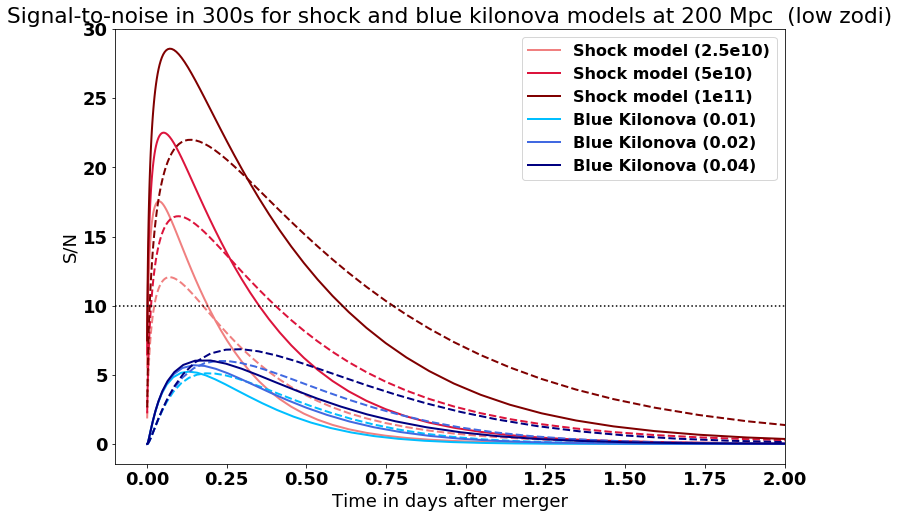

In [18]:
plt.plot(shock_2e10_snr[2,:,0],shock_2e10_snr[2,:,1], color='lightcoral', linestyle='-', linewidth=2, label='Shock model (2.5e10)')
plt.plot(shock_2e10_snr[2,:,0],shock_2e10_snr[2,:,2], color='lightcoral', linestyle='--', linewidth=2, label='_Shock model (2.5e10)')
plt.plot(shock_5e10_snr[2,:,0],shock_5e10_snr[2,:,1], color='crimson', linestyle='-', linewidth=2, label='Shock model (5e10)')
plt.plot(shock_5e10_snr[2,:,0],shock_5e10_snr[2,:,2], color='crimson', linestyle='--', linewidth=2, label='_Shock model (5e10)')
plt.plot(shock_1e11_snr[2,:,0],shock_1e11_snr[2,:,1], color='maroon', linestyle='-', linewidth=2, label='Shock model (1e11)')
plt.plot(shock_1e11_snr[2,:,0],shock_1e11_snr[2,:,2], color='maroon', linestyle='--', linewidth=2, label='_Shock model (1e11)')

plt.plot(blukn_01_snr[2,:,0],blukn_01_snr[2,:,1], color='deepskyblue', linestyle='-', linewidth=2, label='Blue Kilonova (0.01)')
plt.plot(blukn_01_snr[2,:,0],blukn_01_snr[2,:,2], color='deepskyblue', linestyle='--', linewidth=2, label='_Blue Kilonova (0.01)')
plt.plot(blukn_02_snr[2,:,0],blukn_02_snr[2,:,1], color='royalblue', linestyle='-', linewidth=2, label='Blue Kilonova (0.02)')
plt.plot(blukn_02_snr[2,:,0],blukn_02_snr[2,:,2], color='royalblue', linestyle='--', linewidth=2, label='_Blue Kilonova (0.02)')
plt.plot(blukn_04_snr[2,:,0],blukn_04_snr[2,:,1], color='navy', linestyle='-', linewidth=2, label='Blue Kilonova (0.04)')
plt.plot(blukn_04_snr[2,:,0],blukn_04_snr[2,:,2], color='navy', linestyle='--', linewidth=2, label='_Blue Kilonova (0.04)')

plt.axhline(y=10,xmin=0,xmax=1,color='black',linestyle=':')
#plt.ylim(26,18)
plt.xlim(-0.1,2)
plt.legend(fontsize=16)
plt.xlabel('Time in days after merger')
plt.ylabel(r'S/N')
plt.title('Signal-to-noise in 300s for shock and blue kilonova models at 200 Mpc  (low zodi)')
plt.show()

In [19]:
# Remove ABmag units, write to fits tables
shock_2e10_lc['mag_D1'].unit = None
shock_2e10_lc['mag_D2'].unit = None
shock_5e10_lc['mag_D1'].unit = None
shock_5e10_lc['mag_D2'].unit = None
shock_1e11_lc['mag_D1'].unit = None
shock_1e11_lc['mag_D2'].unit = None
blukn_01_lc['mag_D1'].unit = None
blukn_01_lc['mag_D2'].unit = None
blukn_02_lc['mag_D1'].unit = None
blukn_02_lc['mag_D2'].unit = None
blukn_04_lc['mag_D1'].unit = None
blukn_04_lc['mag_D2'].unit = None
shock_2e10_lc.write('../astroduet/data/shock_2.5e10_lightcurve_DUET.fits', format='fits', overwrite=True)
shock_5e10_lc.write('../astroduet/data/shock_5e10_lightcurve_DUET.fits', format='fits', overwrite=True)
shock_1e11_lc.write('../astroduet/data/shock_1e11_lightcurve_DUET.fits', format='fits', overwrite=True)
blukn_01_lc.write('../astroduet/data/blukn_01_lightcurve_DUET.fits', format='fits', overwrite=True)
blukn_02_lc.write('../astroduet/data/blukn_02_lightcurve_DUET.fits', format='fits', overwrite=True)
blukn_04_lc.write('../astroduet/data/blukn_04_lightcurve_DUET.fits', format='fits', overwrite=True)
shock_2e10_lc['mag_D1'].unit = u.ABmag
shock_2e10_lc['mag_D2'].unit = u.ABmag
shock_5e10_lc['mag_D1'].unit = u.ABmag
shock_5e10_lc['mag_D2'].unit = u.ABmag
shock_1e11_lc['mag_D1'].unit = u.ABmag
shock_1e11_lc['mag_D2'].unit = u.ABmag
blukn_01_lc['mag_D1'].unit = u.ABmag
blukn_01_lc['mag_D2'].unit = u.ABmag
blukn_02_lc['mag_D1'].unit = u.ABmag
blukn_02_lc['mag_D2'].unit = u.ABmag
blukn_04_lc['mag_D1'].unit = u.ABmag
blukn_04_lc['mag_D2'].unit = u.ABmag